In [2]:
import os
import sys
HOME_DIR = '/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering'
os.chdir(HOME_DIR)

DATASETS_DIR = f'{HOME_DIR}/datasets'
DATA_DIR = f'{DATASETS_DIR}/08'
W1_FILE = f'{DATA_DIR}/ampc/w1.csv'
W2_FILE = f'{DATA_DIR}/ampc/w2.csv'
W3_FILE = f'{DATA_DIR}/ampc/w3.csv'
W4_FILE = f'{DATA_DIR}/ampc/w4.csv'

print(f'HOME_DIR: {HOME_DIR}')
print(f'DATASETS_DIR: {DATASETS_DIR}')
print(f'DATA_DIR: {DATA_DIR}')
print(f'W1_FILE: {W1_FILE}')
print(f'W2_FILE: {W2_FILE}')
print(f'W3_FILE: {W3_FILE}')
print(f'W4_FILE: {W4_FILE}')

HOME_DIR: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering
DATASETS_DIR: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets
DATA_DIR: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/08
W1_FILE: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/08/ampc/w1.csv
W2_FILE: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/08/ampc/w2.csv
W3_FILE: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/08/ampc/w3.csv
W4_FILE: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/08/ampc/w4.csv


In [3]:
!pip install --upgrade pip --quiet
!pip install -r requirements.txt --quiet

In [4]:
import math
import json
import pandas as pd
import numpy as np

from scipy.integrate import simpson as simps
from scipy.signal import find_peaks

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

# Combine CSV

In [5]:
# Load the CSV files
w1 = pd.read_csv(W1_FILE)
w2 = pd.read_csv(W2_FILE)
w3 = pd.read_csv(W3_FILE)
w4 = pd.read_csv(W4_FILE)

# Combine the datasets
combined_data = pd.concat([w1, w2, w3, w4])

# Save the combined data to a new CSV file
combined_data_file = f'{DATA_DIR}/combined_data.csv'
combined_data.to_csv(combined_data_file, index=False)

print(f'Combined data saved to: {combined_data_file}')
print(combined_data.head())


Combined data saved to: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/08/combined_data.csv
   acc_mean_x_right  acc_mean_y_right  acc_mean_z_right  acc_mean_xyz_right  \
0          -0.17330           0.14864           0.98128              1.1065   
1          -0.40618           0.24715           0.79471              1.0178   
2          -0.49670           0.37167           0.70283              1.0402   
3          -0.28780           0.15882           0.91688              1.0974   
4          -0.56189           0.36946           0.68668              1.3085   

   acc_mean_xy_right  acc_mean_yz_right  acc_mean_zx_right  \
0            0.44735            1.06110            1.03320   
1            0.52388            0.86595            0.96693   
2            0.68213            0.80958            0.96510   
3            0.50834            1.02760            0.99884   
4            0.91759            1.02180            1.12010   

   acc_mean_pitch

In [6]:
# Display basic information about the dataset
print("Dataset Information:")
print(combined_data.info())

# Check the shape of the dataset
print(f"Dataset Shape: {combined_data.shape}")

# Summary statistics
print("Summary Statistics:")
print(combined_data.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 11629 entries, 0 to 2699
Columns: 157 entries, acc_mean_x_right to class
dtypes: float64(128), int64(29)
memory usage: 14.0 MB
None
Dataset Shape: (11629, 157)
Summary Statistics:
       acc_mean_x_right  acc_mean_y_right  acc_mean_z_right  \
count      11629.000000      11629.000000      11629.000000   
mean          -0.211198         -0.042165          0.434423   
std            0.571314          0.531156          0.356463   
min           -1.389800         -1.134400         -0.934200   
25%           -0.660600         -0.554880          0.193610   
50%           -0.345500          0.123040          0.490600   
75%            0.205780          0.440480          0.733890   
max            1.223800          1.125700          1.091400   

       acc_mean_xyz_right  acc_mean_xy_right  acc_mean_yz_right  \
count        11629.000000       11629.000000       11629.000000   
mean             1.128481           0.889659        

In [7]:
# Check for missing values
missing_values = combined_data.isnull().sum()
print("Missing Values:")
print(missing_values[missing_values > 0])

Missing Values:
Series([], dtype: int64)


Class Distribution:
class
2    9693
0    1593
1     343
Name: count, dtype: int64


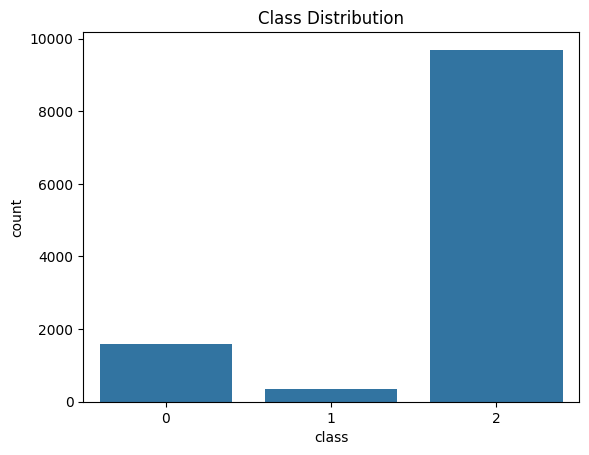

In [8]:
# Distribution of the target variable (last column)
class_distribution = combined_data.iloc[:, -1].value_counts()
print("Class Distribution:")
print(class_distribution)

# Plot the class distribution
sns.countplot(x=combined_data.columns[-1], data=combined_data)
plt.title('Class Distribution')
plt.show()

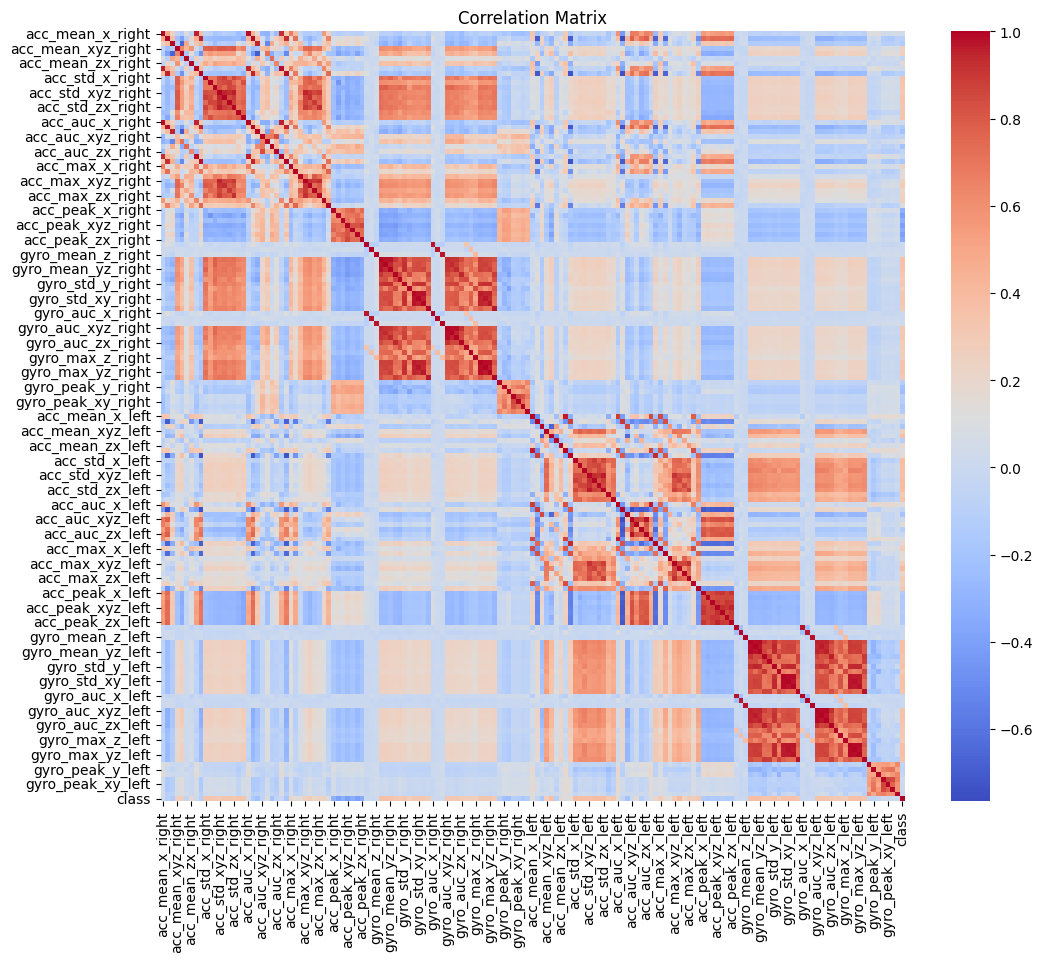

In [9]:
# Compute the correlation matrix
correlation_matrix = combined_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

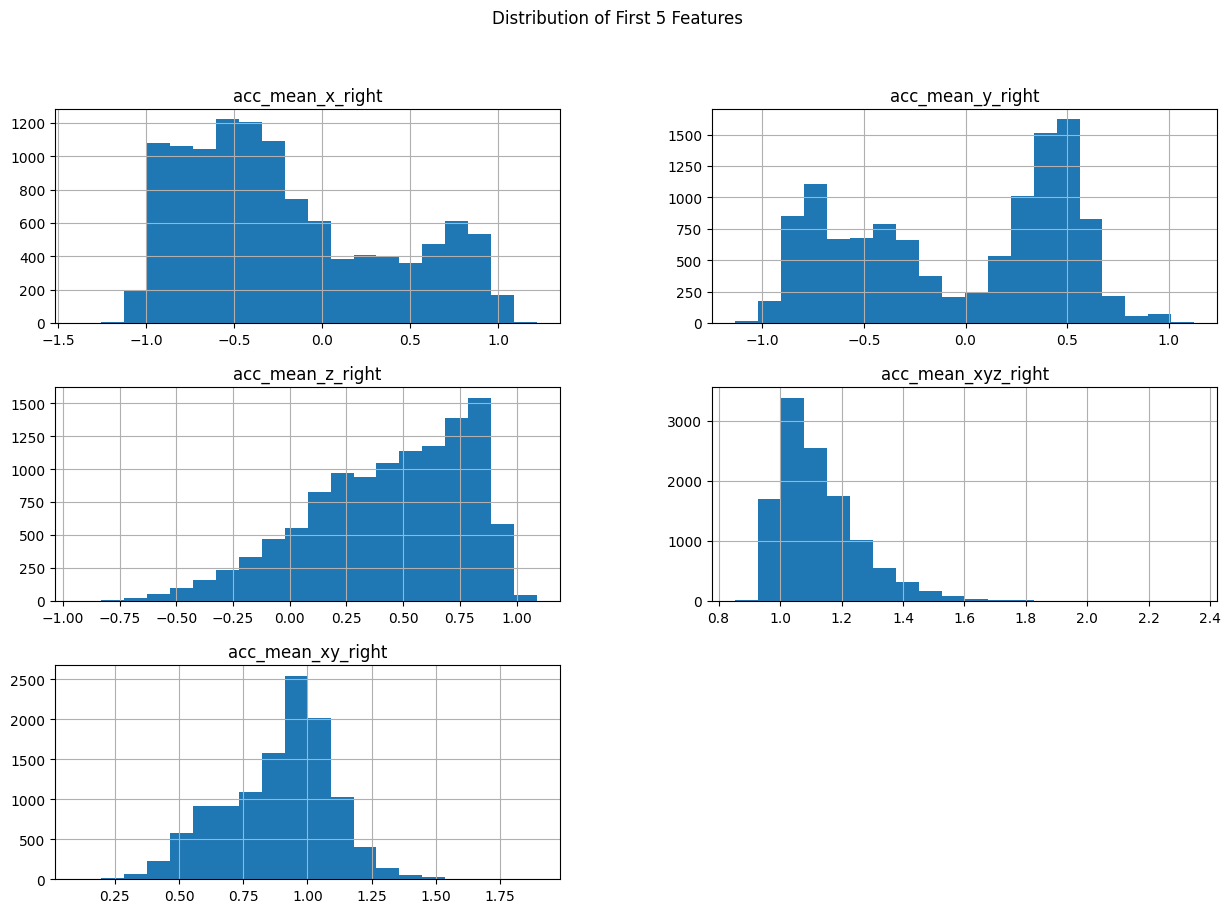

In [10]:
# Plot the distribution of the first 5 features as an example
combined_data.iloc[:, :5].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of First 5 Features")
plt.show()

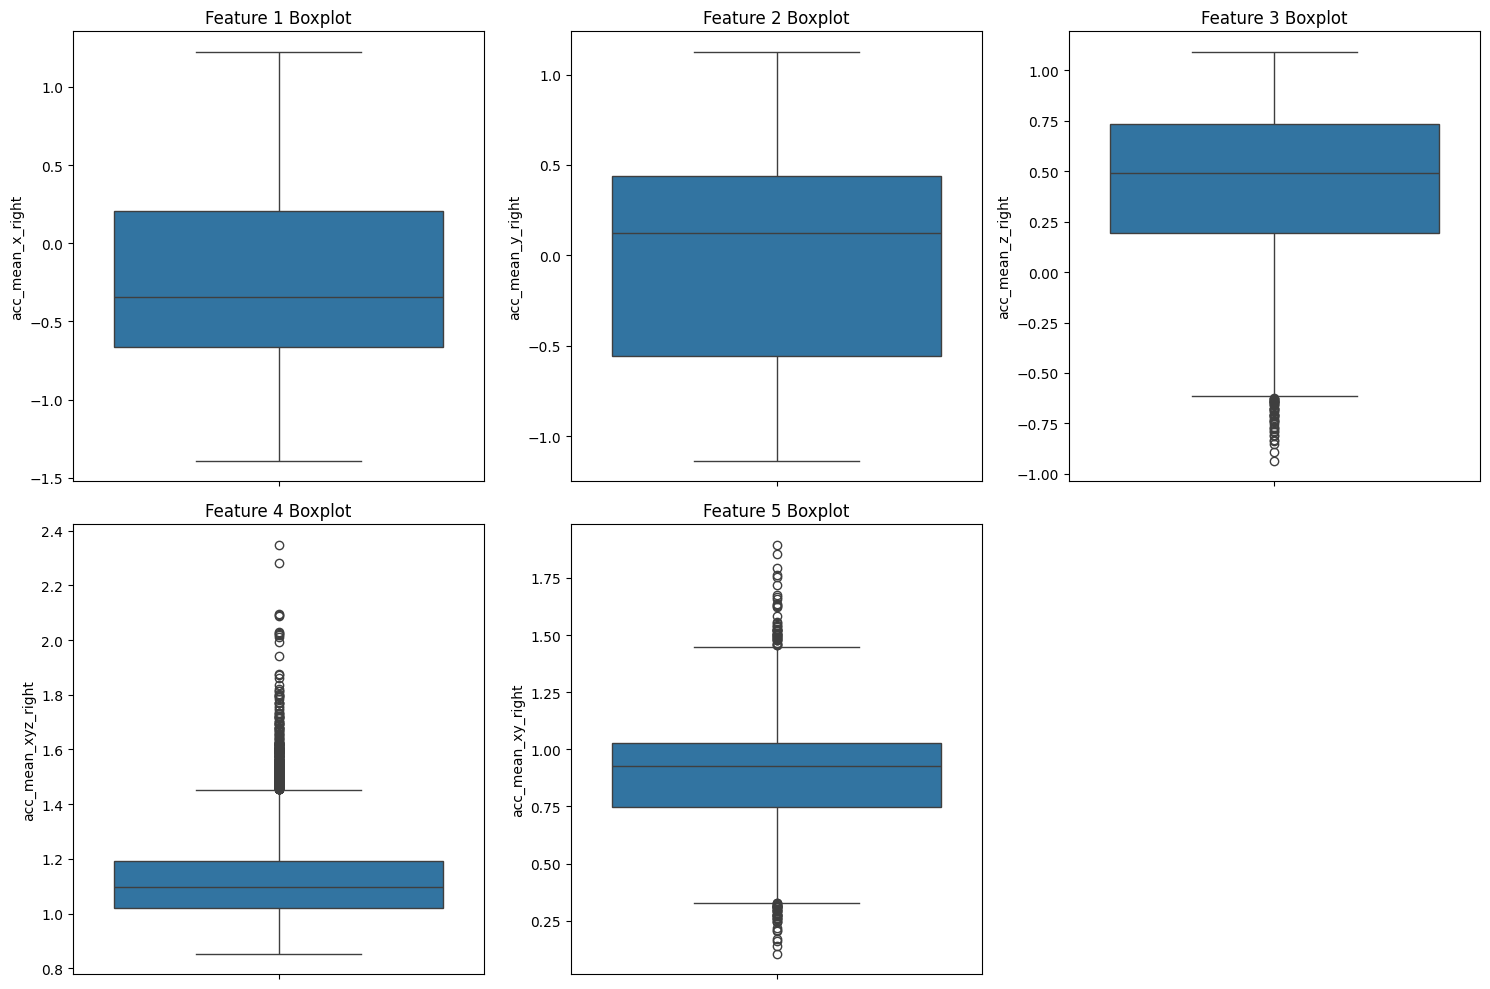

In [11]:
# Plot boxplots to check for outliers in the first 5 features
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=combined_data.iloc[:, i])
    plt.title(f'Feature {i+1} Boxplot')
plt.tight_layout()
plt.show()

In [12]:
# Check variance of all features
feature_variances = combined_data.var()
print("Variance of Features:")
print(feature_variances.sort_values(ascending=False).head(10))  # Display top 10 features with highest variance

Variance of Features:
gyro_auc_xyz_left      2.557144e+06
gyro_auc_xy_left       2.035959e+06
gyro_auc_yz_left       2.021799e+06
gyro_auc_xyz_right     1.838480e+06
acc_auc_roll_right     1.831745e+06
acc_auc_pitch_right    1.705214e+06
gyro_auc_xy_right      1.467743e+06
gyro_auc_yz_right      1.386607e+06
acc_auc_pitch_left     1.263676e+06
gyro_auc_zx_left       9.238919e+05
dtype: float64


In [13]:
# Correlation of each feature with the target variable
target_corr = correlation_matrix.iloc[:, -1].sort_values(ascending=False)
print("Correlation with Target Variable:")
print(target_corr)

Correlation with Target Variable:
class                 1.000000
acc_max_xy_left       0.394694
acc_std_xy_left       0.384698
acc_std_x_left        0.383929
acc_std_yz_left       0.383300
                        ...   
acc_peak_xy_right    -0.338292
acc_peak_zx_right    -0.343141
acc_peak_y_right     -0.401250
acc_peak_xyz_right   -0.401486
acc_peak_yz_right    -0.404735
Name: class, Length: 157, dtype: float64


# Shuffle the Data and Save to all_data.csv

In [14]:
# Shuffle the combined dataset
shuffled_data = combined_data.sample(frac=1, random_state=1).reset_index(drop=True)

# Save the shuffled data to a new CSV file
all_data_file = f'{DATA_DIR}/all_data.csv'
shuffled_data.to_csv(all_data_file, index=False)

print(f'Shuffled data saved to: {all_data_file}')

Shuffled data saved to: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/08/all_data.csv


In [15]:
# NOTE: DATASET TOO LARGE AND TAKES FOREVER TO RUN ON THE MACHINE SO INSTEAD OF TAKING ALL DATA, WE WILL TAKE A SAMPLE OF THE DATA FOR TRAINING AND TESTING

# Shuffle the combined dataset
shuffled_data = combined_data.sample(frac=1, random_state=1).reset_index(drop=True)

# Sample 1% of the shuffled data
sampled_data = shuffled_data.sample(frac=0.01, random_state=1)

# Save the sampled and shuffled data to a new CSV file
sampled_data_file = f'{DATA_DIR}/sampled_all_data.csv'
sampled_data.to_csv(sampled_data_file, index=False)

print(f'Sampled and shuffled data saved to: {sampled_data_file}')


Sampled and shuffled data saved to: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/08/sampled_all_data.csv


# Train the SVM Model with Train-Test Split

In [16]:
# Load the data
all_data = pd.read_csv(sampled_data_file)

# Separate features and labels
X = all_data.iloc[:, :-1]  # All columns except the last one
y = all_data.iloc[:, -1]  # The last column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Train the SVM model
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy:.2f}')


Accuracy on test set: 0.77


# Perform 10-Fold Cross-Validation

In [17]:
# Perform cross-validation
scores = cross_val_score(clf, X, y, cv=10)

print(f'Cross-validation accuracy: {scores.mean():.2f}')


Cross-validation accuracy: 0.76


/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


# Hyperparameter Tuning using GridSearchCV

In [18]:
# Define the parameter grid
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.1, 1, 10]}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=10)
grid_search.fit(X_train, y_train)

# Print best parameters and accuracy
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_:.2f}')

/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best cross-validation accuracy: 0.78


# Retrain the SVM Model with Optimal Hyperparameters

In [19]:
# Retrain the model using the best parameters
best_clf = grid_search.best_estimator_

# Train and test split accuracy
best_clf.fit(X_train, y_train)
y_pred_best = best_clf.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Accuracy with tuned parameters on test set: {accuracy_best:.2f}')

# Cross-validation accuracy with tuned parameters
scores_best = cross_val_score(best_clf, X, y, cv=10)
print(f'Cross-validation accuracy with tuned parameters: {scores_best.mean():.2f}')

Accuracy with tuned parameters on test set: 0.77
Cross-validation accuracy with tuned parameters: 0.76


/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


# Feature Selection using K-Best

In [20]:
# Select the top 100 features
k_best = SelectKBest(f_classif, k=100)
X_k_best = k_best.fit_transform(X, y)

# Train and evaluate with the selected features
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k_best, y, test_size=0.3, random_state=1)
clf_k_best = svm.SVC(kernel='linear')
clf_k_best.fit(X_train_k, y_train_k)
y_pred_k_best = clf_k_best.predict(X_test_k)
accuracy_k_best = accuracy_score(y_test_k, y_pred_k_best)
print(f'Accuracy with K-Best features on test set: {accuracy_k_best:.2f}')

# Cross-validation accuracy with K-Best features
scores_k_best = cross_val_score(clf_k_best, X_k_best, y, cv=10)
print(f'Cross-validation accuracy with K-Best features: {scores_k_best.mean():.2f}')

Accuracy with K-Best features on test set: 0.71


/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


Cross-validation accuracy with K-Best features: 0.76


# Dimensionality Reduction using PCA

In [21]:
# Apply PCA and select top 10 components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Train and evaluate with the PCA features
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=1)
clf_pca = svm.SVC(kernel='linear')
clf_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = clf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
print(f'Accuracy with PCA features on test set: {accuracy_pca:.2f}')

# Cross-validation accuracy with PCA features
scores_pca = cross_val_score(clf_pca, X_pca, y, cv=10)
print(f'Cross-validation accuracy with PCA features: {scores_pca.mean():.2f}')

Accuracy with PCA features on test set: 0.86


/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


Cross-validation accuracy with PCA features: 0.80


# Summary

In [22]:
summary_data = {
    'Model': ['Original features', 'With hyperparameter tuning', 'With K-Best features', 'With PCA features'],
    'Train-test split accuracy': [accuracy, accuracy_best, accuracy_k_best, accuracy_pca],
    'Cross-validation accuracy': [scores.mean(), scores_best.mean(), scores_k_best.mean(), scores_pca.mean()]
}

summary_table = pd.DataFrame(summary_data)
print(summary_table)

                        Model  Train-test split accuracy  \
0           Original features                   0.771429   
1  With hyperparameter tuning                   0.771429   
2        With K-Best features                   0.714286   
3           With PCA features                   0.857143   

   Cross-validation accuracy  
0                   0.756818  
1                   0.756818  
2                   0.759848  
3                   0.803030  


# SGD

In [23]:
# Load the data
all_data = pd.read_csv(sampled_data_file)

# Separate features and labels
X = all_data.iloc[:, :-1]  # All columns except the last one
y = all_data.iloc[:, -1]  # The last column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Initialize and train the SGDClassifier
sgd_clf = SGDClassifier(random_state=1)
sgd_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_sgd = sgd_clf.predict(X_test)
sgd_train_test_accuracy = accuracy_score(y_test, y_pred_sgd)
print(f'SGDClassifier Train-test split accuracy: {sgd_train_test_accuracy:.6f}')

# Perform cross-validation
sgd_cv_scores = cross_val_score(sgd_clf, X, y, cv=10)
sgd_cv_accuracy = sgd_cv_scores.mean()
print(f'SGDClassifier Cross-validation accuracy: {sgd_cv_accuracy:.6f}')

SGDClassifier Train-test split accuracy: 0.885714
SGDClassifier Cross-validation accuracy: 0.818182


/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


# RandomForest

In [24]:
# Load the data
all_data = pd.read_csv(sampled_data_file)

# Separate features and labels
X = all_data.iloc[:, :-1]  # All columns except the last one
y = all_data.iloc[:, -1]  # The last column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Initialize and train the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=1)
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_clf.predict(X_test)
rf_train_test_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'RandomForestClassifier Train-test split accuracy: {rf_train_test_accuracy:.6f}')

# Perform cross-validation
rf_cv_scores = cross_val_score(rf_clf, X, y, cv=10)
rf_cv_accuracy = rf_cv_scores.mean()
print(f'RandomForestClassifier Cross-validation accuracy: {rf_cv_accuracy:.6f}')


RandomForestClassifier Train-test split accuracy: 0.942857


/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


RandomForestClassifier Cross-validation accuracy: 0.897727


# MLP

In [25]:
# Load the data
all_data = pd.read_csv(sampled_data_file)

# Separate features and labels
X = all_data.iloc[:, :-1]  # All columns except the last one
y = all_data.iloc[:, -1]  # The last column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Initialize and train the MLPClassifier
mlp_clf = MLPClassifier(random_state=1, max_iter=300)
mlp_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_mlp = mlp_clf.predict(X_test)
mlp_train_test_accuracy = accuracy_score(y_test, y_pred_mlp)
print(f'MLPClassifier Train-test split accuracy: {mlp_train_test_accuracy:.6f}')

# Perform cross-validation
mlp_cv_scores = cross_val_score(mlp_clf, X, y, cv=10)
mlp_cv_accuracy = mlp_cv_scores.mean()
print(f'MLPClassifier Cross-validation accuracy: {mlp_cv_accuracy:.6f}')

MLPClassifier Train-test split accuracy: 0.828571


/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


MLPClassifier Cross-validation accuracy: 0.819697


In [26]:
summary_data = {
    'Model': ['SVM', 'SGD', 'RandomForest', 'MLP'],
    'Train-test split accuracy': [0.771429, sgd_train_test_accuracy, rf_train_test_accuracy, mlp_train_test_accuracy],
    'Cross-validation accuracy': [0.756818, sgd_cv_accuracy, rf_cv_accuracy, mlp_cv_accuracy]
}

summary_table = pd.DataFrame(summary_data)
print(summary_table)

          Model  Train-test split accuracy  Cross-validation accuracy
0           SVM                   0.771429                   0.756818
1           SGD                   0.885714                   0.818182
2  RandomForest                   0.942857                   0.897727
3           MLP                   0.828571                   0.819697
